# Attention Prediction in a non-calibrated system

The purpose of this notebook is to predict a user's attention, meaning a model to decide whether a user is looking on the laptop's screen or not.  We want to achieve this without calibrating the system and by only using 2D frames from the laptop camera in real-time. 

For the thesis, we have created a dataset with labelled frames(1: looking, 0: not looking) and performed a couple of preprocessing steps to extract 68 facial landmarks on the face and the 2 iris points calculated by Loceye's eye-tracking algorithms. 
Below, we will try out different data architectures and classifiers to figure out the best performance.
To achieve real-time performance and non-biased behaviour, we do not want to include any calibrating process. Therefore we will approximate a mapping between the 2D camera points and the 3D world by solving the [Perspective-n-Point](https://en.wikipedia.org/wiki/Perspective-n-Point) problem using the built-in OpenCV method solvePnP. This way, we will obtain the Rotation and Translation matrix(3x1 each) for each frame. Afterwards, we will use them in different architectures to train a machine learning model that will predict the final output. The architectures presented below are:

 - Feed the raw two vectors in a classifier.
 - Feed the two vectors and the 2 iris points.

### Import packages

In [1]:
import numpy as np
import cv2
import dlib
from imutils import face_utils
import glob
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
import json

### 3D Model points for SolvePnP
We will approximate the 3D points of the following face parts with the correspoinding coordinates. This is a general model of the human face and we do not need to worry much about absolute accuracy.

In [2]:
# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                         
                        ])

### Load Dataset

In [3]:
# Number of training examples to use(0-3084)
DATASET_SIZE = 3084
DEBUG = False

# Load the dataset
with open('data.json') as json_file:
    data_all = json.load(json_file)

# Extract the keys in sorted order
keys = sorted(data_all)

# Convert python list to np array
keys = np.asarray(keys)
print(keys.shape)

# Uncomment if you want to use a smaller dataset and not the full one
# rand_indices = np.random.randint(3084, size=DATASET_SIZE)
# keys = keys[rand_indices]
print(keys.shape)

(3084,)
(3084,)


***

# Architecture #1

#### In this data architecture we will use as input the translation vector and rotation vector, each one of shape (3, 1) so a signle training example of our dataset will be of shape (6, 1). 

In [4]:
X = np.zeros((DATASET_SIZE, 6, 1))
y = np.zeros(DATASET_SIZE)

for i in range(DATASET_SIZE):
    key = keys[i]
        
    # Check if it is positive or negative example
    output = key.split('/')[1]
    if(output == 'positive'):
        y[i] = 1
    elif(output == 'negative'):
        y[i] = 0
        
    # Approximate camera intrinsic parameters
    im = cv2.imread('dataset/' + key)   # This imread is time consuming! Another way?
    size = im.shape
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
                             [[focal_length, 0, center[0]],
                             [0, focal_length, center[1]],
                             [0, 0, 1]], dtype = "double"
                             )
    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    
    landmarks = data_all[key]['landmarks']
    
    # Grab the 2D coordinates of our six sample points
    image_points = np.array([
        (landmarks[33]['x'], landmarks[33]['y']) ,     # Nose tip
        (landmarks[8]['x'], landmarks[8]['y']),     # Chin
        (landmarks[36]['x'], landmarks[36]['y']),     # Left eye left corner
        (landmarks[45]['x'], landmarks[45]['y']),     # Right eye right corner
        (landmarks[48]['x'], landmarks[48]['y']),     # Left Mouth corner
        (landmarks[54]['x'], landmarks[54]['y'])      # Right mouth corner
    ], dtype="double")
    
    # Solve the PnP problem with the parameters specified above
    # and obtain rotation and translation vectors
    (success, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
        )
    
    X[i, :] = np.concatenate((rotation_vector, translation_vector), axis=0)
    
    # DEBUGGING
    if(DEBUG and i <= 10):
        # Project a 3D point (0, 0, 1000.0) onto the image plane.
        # We use this to draw a line sticking out of the nose
        (nose_end_point2D, jacobian) = cv2.projectPoints(
            np.array([(0.0, 0.0, 500.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs
            )
        for p in image_points:
            cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)
        p1 = ( int(image_points[0][0]), int(image_points[0][1]) )
        p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]) )
        
        # Draw a line connecting the two points. This line must show
        # the direction out of the nose
        cv2.line(im, p1, p2, (255,0,0), 2)
        # Display image
        cv2.imshow("Output", im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        print("Rotation Vector:\n {0}".format(rotation_vector))
        print("Translation Vector:\n {0}".format(translation_vector))


X = X.squeeze()
print(X.shape)
print(y.shape)

(3084, 6)
(3084,)


#### Data Preproccessing: Normalize features to have 0 mean and 1 Std
We obtain the mean and std from the first 800 examples and not the whole dataset beacause computations crush with too many exmaples and give infinite mean and std

In [5]:
print(X[1000:1005, :])

[[-3.00551937e+00  1.45078022e-01  4.76767504e-01  7.95712968e+01
  -3.92782853e+01  2.76019804e+03]
 [-3.04554883e+00  9.05243587e-02 -3.07827588e-01  1.95291887e+02
  -2.31782775e+00  2.75736773e+03]
 [-3.00660977e+00  1.51251722e-01  5.22350233e-01  9.21191347e+01
  -3.85456010e+01  2.76212599e+03]
 [-3.00558778e+00  8.01227450e-02 -2.23640283e-01  2.10849908e+02
   7.66908812e+01  2.71377602e+03]
 [-3.01596605e+00  9.21469966e-02 -1.64322200e-01  1.97475436e+02
   5.58485825e+01  2.73608906e+03]]


#####  Before normalization:

In [6]:
m = X[0:1000, :].mean(axis=0)
std = X[0:1000, :].std(axis=0)

print('Mean: ', m)
print('Std: ', std)

Mean:  [-2.57750853e+00  2.59756409e-02  6.94960123e-02  1.70568095e+02
  5.29112770e+00  2.27197605e+03]
Std:  [1.22773270e+00 6.42579433e-01 4.13830849e-01 2.61512303e+02
 1.73896971e+02 9.22001517e+02]


In [7]:
X_scaled = (X-m)/std

##### After normalization:

In [8]:
print('Mean:', X_scaled[2000:2500].mean(axis=0))
print('Std: ', X_scaled[0:1000].std(axis=0))
print(y.shape)

Mean: [-0.15021119  0.00829007 -0.14881449  0.57646358 -0.49718561 -0.51012038]
Std:  [1. 1. 1. 1. 1. 1.]
(3084,)


### Shuffle and split dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

print(y_test.shape)
print(X_train[0:5, :])

(617,)
[[-0.40028324 -0.27553056  0.46047607 -0.7116711   1.60815307  0.17539378]
 [-0.25054933 -0.08686839  1.84718583 -1.09155172 -0.05586965 -0.35118346]
 [-0.26029849 -0.08797038 -0.07111495  0.90232577 -0.69480335  1.51918708]
 [-0.28336293  0.16070103  0.2101943   0.49552943 -1.82448638 -0.13917769]
 [ 4.70770213  0.46556741  0.53965121  0.91897097  0.53531458 -0.20582178]]


# Train different classifiers
Here we will try out 3 classifiers and compare their results:
 - A SVM with rbf kernel and penalty parameter C=100
 - A Logistic Regression classifer
 - A Random Forest Classifier

In [53]:
# Number of classifiers to train in order to summarize the results
NUM_OF_CLASSIFIERS = 10
Y_SVM, Y_LR, Y_RF = np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS))

### SVM Classifier

In [54]:
from sklearn import svm

for i in range(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
    
    svm_classifier = svm.SVC(C=100, kernel='rbf', gamma='auto')
    svm_classifier.fit(X_train, y_train)
    y_pred_svm = svm_classifier.predict(X_test)
    Y_SVM[i] = metrics.accuracy_score(y_test, y_pred_svm)

# Print the last result
print('Training set accuracy for SVM:', svm_classifier.score(X_train, y_train))
print('Test set accuracy for SVM: ', metrics.accuracy_score(y_test, y_pred_svm))

Training set accuracy for SVM: 0.7126064045399271
Test set accuracy for SVM:  0.6304700162074555


### Logistic Regression Classifier

In [55]:
from sklearn.linear_model import LogisticRegression

for i in range(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
    
    lr_classifier = LogisticRegression(solver='lbfgs')
    lr_classifier.fit(X_train, y_train)
    y_pred_lr = lr_classifier.predict(X_test)
    Y_LR[i] = metrics.accuracy_score(y_test, y_pred_lr)

print('Training set accuracy for Logistic Regression:', lr_classifier.score(X_train, y_train))
print('Test set accuracy for Logistic Regression: ', metrics.accuracy_score(y_test, y_pred_lr))

Training set accuracy for Logistic Regression: 0.526145115524929
Test set accuracy for Logistic Regression:  0.5170178282009724


### Random Forst Classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier

for i in range(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
    
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)
    rf_classifier.fit(X_train, y_train)
    y_pred_rf = rf_classifier.predict(X_test)
    Y_RF[i] = metrics.accuracy_score(y_test, y_pred_rf)

print('Training set accuracy for Random Forst:', rf_classifier.score(X_train, y_train))
print('Test set accuracy for Random Forest: ', metrics.accuracy_score(y_test, y_pred_rf))

Training set accuracy for Random Forst: 1.0
Test set accuracy for Random Forest:  0.6904376012965965


## Visualize & Summarize results for Architecture #1

We trained the 3 classifiers for 10 different train/test splits and the accuracy results are shown below

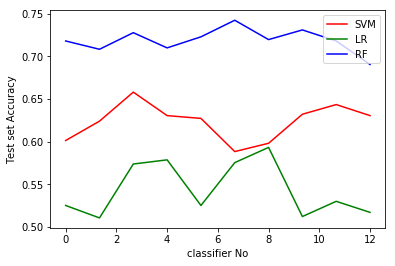

In [57]:
import matplotlib.pyplot as plt

t = np.linspace(0, NUM_OF_CLASSIFIERS+2, NUM_OF_CLASSIFIERS)
plt.plot(t, Y_SVM, 'r')
plt.plot(t, Y_LR, 'g')
plt.plot(t, Y_RF, 'b')
plt.xlabel('classifier No')
plt.ylabel('Test set Accuracy')
plt.legend(('SVM', 'LR', 'RF'))

plt.show()

The best out of 10 scores for each classifier is presented below

Metric                | SVM        | Logistic Regression | Random Forest |
:----:                | :--------: | :-----------------: | :-----:       |
Training set Accuracy | 0.701      | 0.580               | 1             | 
Test set Accuracty    | 0.640      | 0.581               | 0.726         |

We clearly see that the Random Forest classifier with 100 trees outperfomrs the other 2, reaching 72,6% accuracy!

***

# Architecture #2
#### In this data architecture we will use as input the translation vector and rotation vector plus the 2 iris points) so a signle training example of our dataset will be of shape (10, 1). 
We already have the array X of shape (6, 1) containing the rotation and translation vectors stacked so we only need to extract the iris points from our data.json.

In [5]:
DATASET_SIZE = 3084
X2 = np.zeros((DATASET_SIZE, 10))
for i in range(DATASET_SIZE):
    key = keys[i]
    iris_right = np.asarray(data_all[key]['iris_right'])
    iris_left = np.asarray(data_all[key]['iris_left'])
    X2[i, :] = np.concatenate((X[i, :], iris_left, iris_right), axis = 0)
print(X2.shape)

(3084, 10)


The following steps are the same as for the first architecture

In [42]:
print(X2[1000:1005])

[[-3.00551937e+00  1.45078022e-01  4.76767504e-01  7.95712968e+01
  -3.92782853e+01  2.76019804e+03  6.25004729e+02  2.55122853e+02
   7.52216725e+02  2.41467233e+02]
 [-3.04554883e+00  9.05243587e-02 -3.07827588e-01  1.95291887e+02
  -2.31782775e+00  2.75736773e+03  6.51599474e+02  2.74633597e+02
   7.80190422e+02  2.66374984e+02]
 [-3.00660977e+00  1.51251722e-01  5.22350233e-01  9.21191347e+01
  -3.85456010e+01  2.76212599e+03  6.30616018e+02  2.55011379e+02
   7.57703846e+02  2.43255612e+02]
 [-3.00558778e+00  8.01227450e-02 -2.23640283e-01  2.10849908e+02
   7.66908812e+01  2.71377602e+03  6.60564201e+02  3.02714393e+02
   7.92862665e+02  2.95378319e+02]
 [-3.01596605e+00  9.21469966e-02 -1.64322200e-01  1.97475436e+02
   5.58485825e+01  2.73608906e+03  6.54926899e+02  2.94318558e+02
   7.88320997e+02  2.85512182e+02]]


In [43]:
m = X2[0:1000, :].mean(axis=0)
std = X2[0:1000, :].std(axis=0)

X2_scaled = (X2-m)/std

In [44]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=0.2)
print(y2_test.shape)
print(X2_train[0:5, :])

(617,)
[[-0.15311976  0.1181148   0.32857098 -0.8476953   0.59717406 -1.07068288
  -1.10578933 -0.26787303 -0.79551079 -0.27215597]
 [-0.31574663 -0.03886493 -1.94354028  0.57033541 -0.63370709 -0.13531208
  -0.34814589 -0.68666897 -0.41543208 -0.58509744]
 [-0.34944203 -0.03001236 -0.4842914   0.76771575 -0.21242533 -0.47675973
  -0.16114423 -0.59389517 -0.16312724 -0.56414606]
 [-0.14817198  0.17653519  1.18406482 -0.63900982  0.54241242 -0.43528376
  -0.75269903 -0.0776089  -0.72577804 -0.13068308]
 [-0.24509526  0.09435211 -2.04551198  0.88139624 -0.04162169 -0.43786235
  -0.18247935 -0.39447237 -0.24718728 -0.43534045]]


# Train different classifiers
Here we will try out 3 classifiers and compare their results:
 - A SVM with rbf kernel and penalty parameter C=100
 - A Logistic Regression classifer
 - A Random Forest Classifier

In [46]:
# Number of classifiers to train in order to summarize the results
NUM_OF_CLASSIFIERS = 10
Y_SVM2, Y_LR2, Y_RF2 = np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS))

### SVM classifier

In [47]:
from sklearn import svm
for i in range(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=0.2)
    
    svm_classifier2 = svm.SVC(C=100, kernel='rbf', gamma='auto')
    svm_classifier2.fit(X2_train, y2_train)
    y2_pred_svm = svm_classifier2.predict(X2_test)
    Y_SVM2[i] = metrics.accuracy_score(y2_test, y2_pred_svm)

print('Training set accuracy for SVM:', svm_classifier2.score(X2_train, y2_train))
print('Test set accuracy for SVM: ', metrics.accuracy_score(y2_test, y2_pred_svm))

Training set accuracy for SVM: 0.7401702472638833
Test set accuracy for SVM:  0.6985413290113452


### Logistic Regression Classifier

In [48]:
from sklearn.linear_model import LogisticRegression

for i in range(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=0.2)
    
    lr_classifier2 = LogisticRegression(solver='lbfgs')
    lr_classifier2.fit(X2_train, y2_train)
    y2_pred_lr = lr_classifier2.predict(X2_test)
    Y_LR2[i] = metrics.accuracy_score(y2_test, y2_pred_lr)

print('Training set accuracy for Logistic Regression:', lr_classifier2.score(X2_train, y2_train))
print('Test set accuracy for Logistic Regression: ', metrics.accuracy_score(y2_test, y2_pred_lr))

Training set accuracy for Logistic Regression: 0.5164167004458857
Test set accuracy for Logistic Regression:  0.5769854132901134


### Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

for i in range(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=0.2)
    
    rf_classifier2 = RandomForestClassifier(n_estimators=100, random_state=1)
    rf_classifier2.fit(X2_train, y2_train)
    y2_pred_rf = rf_classifier2.predict(X2_test)
    Y_RF2[i] = metrics.accuracy_score(y2_test, y2_pred_rf)

print('Training set accuracy for Random Forst:', rf_classifier2.score(X2_train, y2_train))
print('Test set accuracy for Random Forest: ', metrics.accuracy_score(y2_test, y2_pred_rf))

Training set accuracy for Random Forst: 1.0
Test set accuracy for Random Forest:  0.7568881685575365


## Visualize & Summarize results for Architecture #2


We trained the 3 classifiers for 25 different train/test splits and the accuracy results are shown below

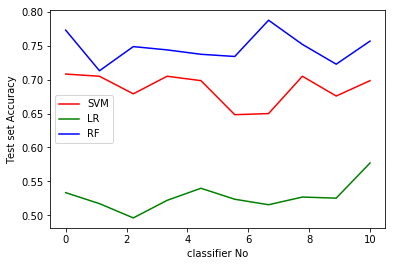

0.7082658022690438 0.5769854132901134 0.7876823338735819


In [52]:
import matplotlib.pyplot as plt

t = np.linspace(0, NUM_OF_CLASSIFIERS, NUM_OF_CLASSIFIERS)
plt.plot(t, Y_SVM2, 'r')
plt.plot(t, Y_LR2, 'g')
plt.plot(t, Y_RF2, 'b')
plt.xlabel('classifier No')
plt.ylabel('Test set Accuracy')
plt.legend(('SVM', 'LR', 'RF'))

plt.show()
print(Y_SVM2.max(axis=0), Y_LR2.max(axis=0), Y_RF2.max(axis=0))

Metric                | SVM        | Logistic Regression | Random Forest |
:----:                | :--------: | :-----------------: | :-----:       |
Training set Accuracy | 0.752      | 0.533               | 1             | 
Test set Accuracty    | 0.716      | 0.588               | 0.770         |

The difference between the first and the second architecture is noticeable.
The SVM  method is more accurate now approaching the Random Forest accuracy, which also improved in but not as much as the SVM. Also, the Logistic Regression classifier seems unable to handle our Dataset in both architectures; therefore, we will not consider it for the next of our research. The best accuracy scored, 77%, is achieved by Random Forest classifier in our second data architecture.

***

# Architecture #3
In this archtecture we will use the difference vector between the iris and the inner edge point of the eye(Maybe add and image here?). First, we will keep the raw iris coordinates and add the 2 vectors to our training data, yielding to a shape of (14, 1). Afterwards we will try removing the absolute coordinates of the iris and compare the 2 results.

Previously on this notebook we had extracted the 68 facial landmarks as well as the two iris points. The 2 inner eye points are the landmarks 39 and 42

In [11]:
# Dataset construction

DATASET_SIZE = 3084
X3 = np.zeros((DATASET_SIZE, 14))
X4 = np.zeros((DATASET_SIZE, 10))
for i in range(DATASET_SIZE):
    key = keys[i]
    
    landmarks = data_all[key]['landmarks']
    iris_right = np.asarray(data_all[key]['iris_right'])
    iris_left = np.asarray(data_all[key]['iris_left'])
    
    left_vector = np.asarray( (abs(iris_left[0] - landmarks[39]['x']), abs(iris_left[1] - landmarks[39]['y'])) )
    right_vector = np.asarray( (abs(iris_right[0] - landmarks[42]['x']), abs(iris_right[1] - landmarks[42]['y'])) )
    X3[i] = np.concatenate((X2[i], left_vector, right_vector), axis=0)
#     X4[i] = np.concatenate((X2[i, 0:6], left_vector, right_vector), axis=0)
    
    if DEBUG:
        im = cv2.imread('dataset/' + key)
        cv2.circle(im, (int(iris_left[0]), int(iris_left[1])), 3, (0,0,255), -1)
        cv2.circle(im, (int(iris_right[0]), int(iris_right[1])), 3, (0,0,255), -1)
        cv2.circle(im, (landmarks[39]['x'], landmarks[39]['y']), 3, (0,0,255), -1)
        cv2.circle(im, (landmarks[42]['x'], landmarks[42]['y']), 3, (0,0,255), -1)
        cv2.imshow('Im', im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

print(X3.shape)

(3084, 14)


In [12]:
m = X3[0:1000, :].mean(axis=0)
std = X3[0:1000, :].std(axis=0)
X3_scaled = (X3-m)/std

In [13]:
# Number of classifiers to train in order to summarize the results
NUM_OF_CLASSIFIERS = 25
Y_SVM3, Y_LR3, Y_RF3 = np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS))

### SVM Classifier

In [24]:
from sklearn import svm

for i in range(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_scaled, y, test_size=0.2)
    
    svm_classifier3 = svm.SVC(C=100, kernel='rbf', gamma='auto')
    svm_classifier3.fit(X3_train, y3_train)
    y3_pred_svm = svm_classifier3.predict(X3_test)
    Y_SVM3[i] = metrics.accuracy_score(y3_test, y3_pred_svm)

# Print the last result
print('Training set accuracy for SVM:', svm_classifier3.score(X3_train, y3_train))
print('Test set accuracy for SVM: ', metrics.accuracy_score(y3_test, y3_pred_svm))

Training set accuracy for SVM: 0.8775841102553709
Test set accuracy for SVM:  0.7893030794165316


### Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

for i in range(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_scaled, y, test_size=0.2)
    
    rf_classifier3 = RandomForestClassifier(n_estimators=50, random_state=1)
    rf_classifier3.fit(X3_train, y3_train)
    y3_pred_rf = rf_classifier3.predict(X3_test)
    Y_RF3[i] = metrics.accuracy_score(y3_test, y3_pred_rf)

print('Training set accuracy for Random Forst:', rf_classifier3.score(X3_train, y3_train))
print('Test set accuracy for Random Forest: ', metrics.accuracy_score(y3_test, y3_pred_rf))

Training set accuracy for Random Forst: 1.0
Test set accuracy for Random Forest:  0.8038897893030794


### Visualize & Summarize results for Architecture #3

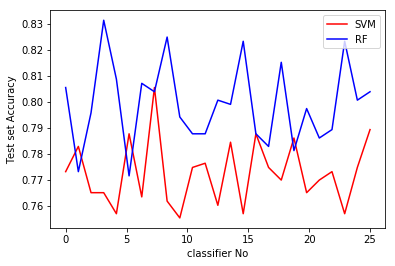

0.8055105348460292 0.8314424635332253


In [28]:
import matplotlib.pyplot as plt

t = np.linspace(0, NUM_OF_CLASSIFIERS, NUM_OF_CLASSIFIERS)
plt.plot(t, Y_SVM3, 'r')
plt.plot(t, Y_RF3, 'b')
plt.xlabel('classifier No')
plt.ylabel('Test set Accuracy')
plt.legend(('SVM', 'RF'))

plt.show()
print(Y_SVM3.max(axis=0), Y_RF3.max(axis=0))

At this point we also tried feeding the difference vectors only without the absolute iris location, reaching an overall accuracy 2% lower than the one above.

In [17]:
print(metrics.confusion_matrix(y3_test, y3_pred_rf))

[[207  57]
 [ 64 289]]
